In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import copy
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [8]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 21) (14680,) (1840, 21) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'event'],
      dtype='object')


# Random Forest

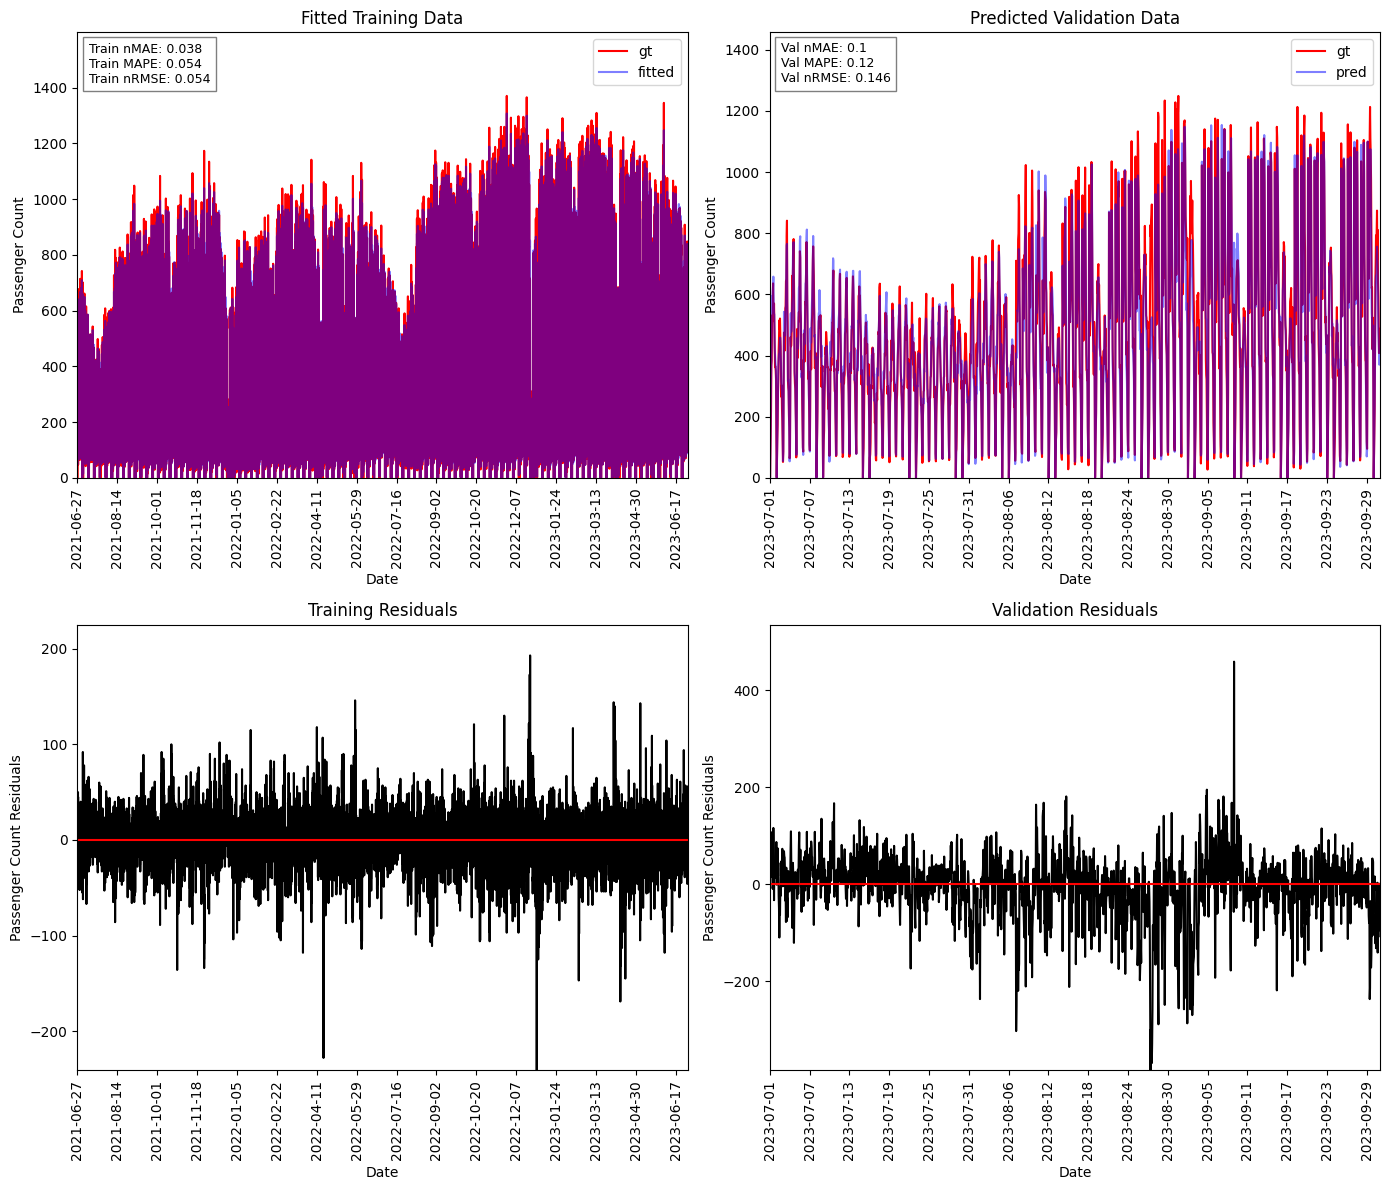

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForestRegressor(n_estimators=250, random_state=42)


In [80]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20*agg, 40*agg, 60*agg, 80*agg, 100*agg, 120*agg, 140*agg]
differentiation = None
n_estimators = 250

# best 60 min with diff
#lags = [20, 40, 60, 80, 100, 120, 140]
#differentiation = 1
#n_estimators = 250


model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower=None, y_val_upper=None,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

print(model.get_params())
print(model)

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
#                                  y_train_true=y_train, y_val_true=y_val,
#                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
#                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

## Grid search

In [3]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()
#iterator = 0

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for lags in laglist:
                            model = RandomForestRegressor(
                                n_estimators=n_estimators,
                                random_state=42)
                            model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                        
                            trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                            valMAE = nMAE(y=y_val, yhat=y_val_pred)
                            if valMAE < bestMAE:
                                bestMAE = valMAE
                                best_model = model
                                best_y_train_pred = y_train_pred
                                best_y_val_pred = y_val_pred
                                best_lags = lags
                                best_n_estimator = n_estimators
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model, f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{best_model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

1A 60min:

Diff=None

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 100      & None\\
\hline
F-RF-C   & 5      & None\\
\hline
F-RF-CW  & 30      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 100      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 100      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 250      & None\\
\hline
F-RF-C   & 50      & None\\
\hline
F-RF-CW  & 250      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 250      & [1, 4, 8, 20, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# XGBoost

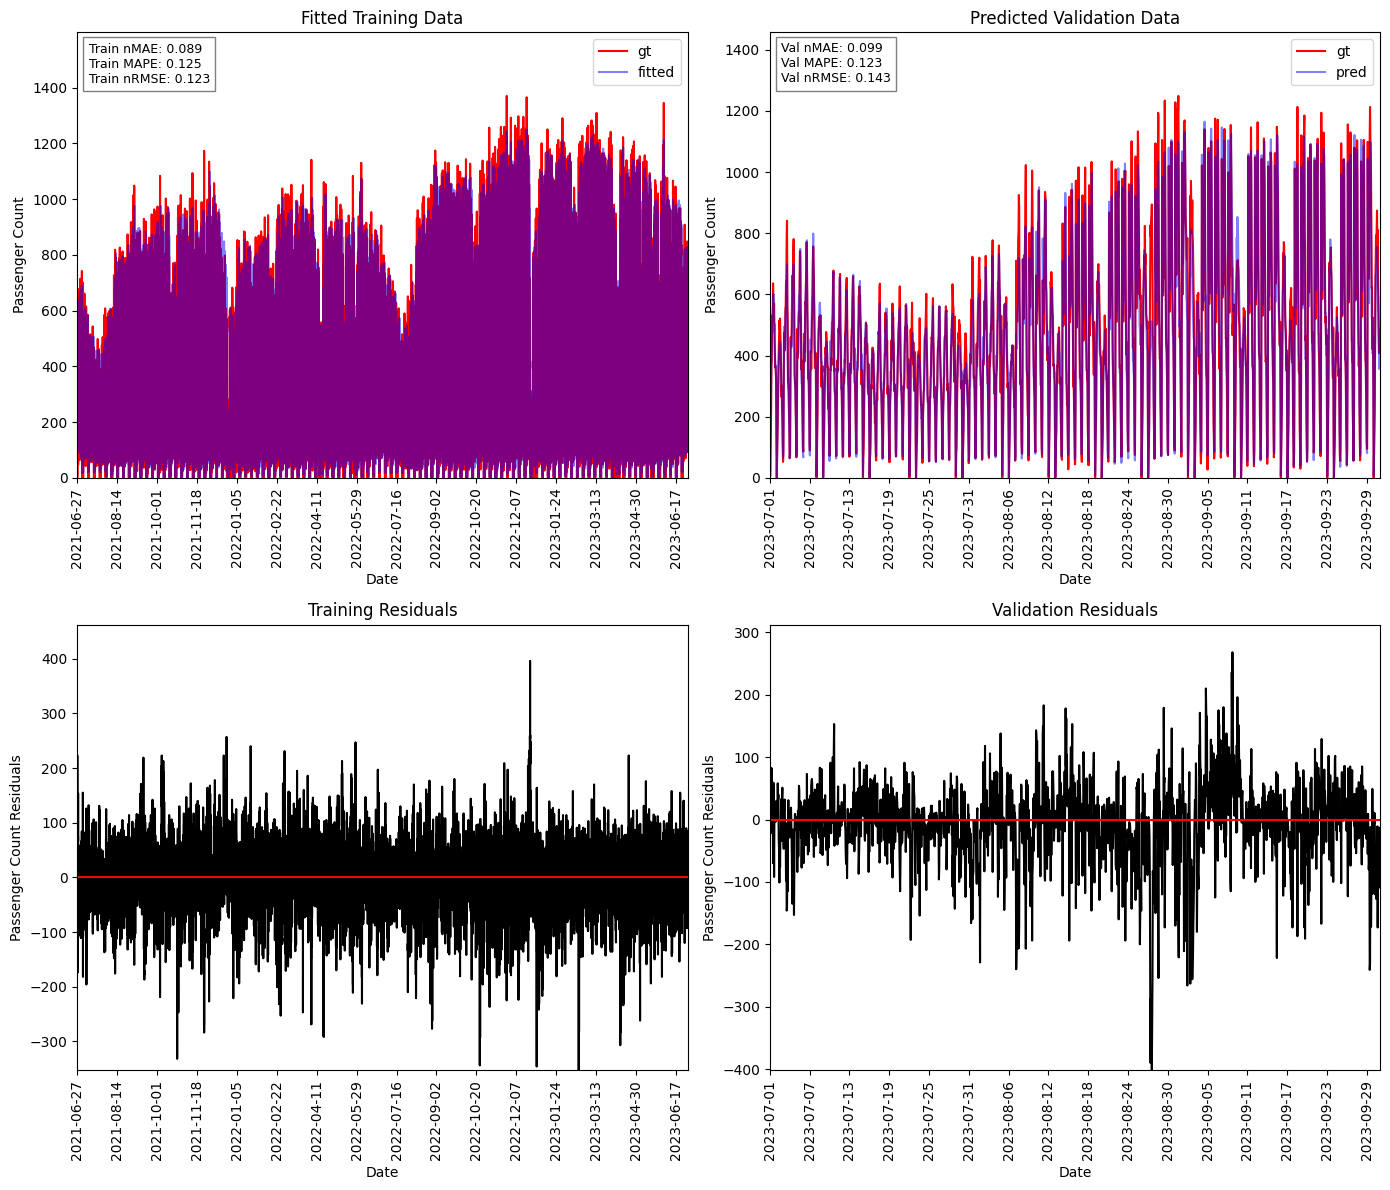

In [6]:
# fixed window 40 hours ahead
horizon = 40*agg

# 1. best 60 min without diff
differentiation = None
lags = [20*agg, 40*agg, 60*agg, 80*agg, 100*agg, 120*agg, 140*agg]
n_estimators = 100
alpha = 0.3
eta = 0.1

# 2. best 60 min without diff
#differentiation = None
#lags = [20*agg, 40*agg, 60*agg, 80*agg, 100*agg, 120*agg, 140*agg]
#n_estimators = 50
#alpha = 0.1
#eta = 0.1

# 2. best 60 min with diff
#differentiation = 1
#lags = [20, 40, 60, 80, 100, 120, 140]
#n_estimators = 20
#alpha = 0.0
#eta = 0.2

model = XGBRegressor(n_estimators=n_estimators, alpha=alpha, eta=eta, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower=None, y_val_upper=None,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
#                                  y_train_true=y_train, y_val_true=y_val,
#                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
#                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

## Grid search

In [54]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for alpha in [0.0, 0.1, 0.2, 0.3, 0.5]:
                            for eta in [0.01, 0.05, 0.1, 0.2, 0.3]: #[]:
                                for lags in laglist:
                                    model = XGBRegressor(n_estimators=n_estimators, 
                                                         eta=eta,
                                                         alpha=alpha, 
                                                         seed=42)
                                    model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                        differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                        horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                        X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                    
                                    trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                                    valMAE = nMAE(y=y_val, yhat=y_val_pred)
                                    if valMAE < bestMAE:
                                        bestMAE = valMAE
                                        best_model = model
                                        best_y_train_pred = y_train_pred
                                        best_y_val_pred = y_val_pred
                                        best_n_estimator = n_estimators
                                        best_alpha = alpha
                                        best_eta = eta
                                        best_lags = lags
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model.get_xgb_params(), f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}, alpha L1: {best_alpha}, eta: {best_eta}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

1A 60min:

Diff=None

$$
\begin{array}{c|c|c|c|c}
Model     & n\_estimators & \alpha L1 & \eta & Lags\\
\hline
F-XGB-W   & 10            & 0.3       & 0.2  & None\\
\hline
F-XGB-C   & 10            & 0.0       & 0.2  & None\\
\hline
F-XGB-CW  & 10            & 0.1       & 0.3  & None\\
\hline
F-XGB-L   & 100           & 0.5       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LW  & 100           & 0.0       & 0.05 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LC  & 100           & 0.3       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LCW & 50            & 0.1       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c|c|c}
Model     & n\_estimators & \alpha (L1) & \eta & Lags\\
\hline
F-XGB-W   & 5             & 0.2       & 0.3  & None\\
\hline
F-XGB-C   & 20            & 0.3       & 0.2  & None\\
\hline
F-XGB-CW  & 100           & 0.2       & 0.1  & None\\
\hline
F-XGB-L   & 50            & 0.0       & 0.1  & [1, 4, 8, 20, 140]\\
\hline
F-XGB-LW  & 100           & 0.3       & 0.05 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LC  & 250           & 0.2       & 0.05 & [1, 20, 140]\\
\hline
F-XGB-LCW & 20            & 0.0       & 0.2  & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# LOCO Feature Importance

In [3]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=[target])
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=[target])
y_val = df_val[target]

In [7]:
# Random Forest
laglist = [20, 40, 60, 80, 100, 120, 140]
model = RandomForestRegressor(n_estimators=250, random_state=42)

horizon = 40*agg
differentiation = None
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None
use_exog = True
interval = None

names_to_ignore = [Columns.calendar_fallVacation.value, Columns.calendar_easterVacation.value, Columns.calendar_summerVacation.value,
                   Columns.calendar_winterVacation.value, Columns.calendar_christmasVacation.value,
                   Columns.calendar_Q1.value, Columns.calendar_Q2.value, Columns.calendar_Q3.value, Columns.calendar_Q4.value,
                   Columns.calendar_workdayPlan.value, Columns.calendar_saturdayPlan.value, Columns.calendar_sundayAndHolidayPlan.value]

X_train_temp = copy(X_train)
X_val_temp = copy(X_val)

to_drop = [Columns.calendar_mon.value, Columns.calendar_tue.value, Columns.calendar_thu.value, Columns.calendar_wed.value,
           Columns.calendar_wed.value, Columns.calendar_sat.value,
           Columns.weather_mean_cloud_cover.value, Columns.weather_bright_sunshine.value,
           Columns.weather_acc_precip.value, Columns.weather_mean_pressure.value]
###############
# X_train_temp = X_train_temp.drop(columns=to_drop)
# X_val_temp = X_val_temp.drop(columns=to_drop)
###############

while True:
    # find feature importances
    _, fi_loco_val = utils.Sklearn.loco_feature_importance(X_train_temp, y_train, X_val_temp, y_val, 
                                            model, laglist, horizon, differentiation, 
                                            scalar, exog_scalar, window_type, window_size, use_exog, interval)
    # find low importance features
    feature_score_worst = 10000
    feature_name_worst = None
    for feature_name, feature_score in fi_loco_val.items():
        if feature_score < feature_score_worst and feature_name not in names_to_ignore:
            feature_score_worst = feature_score
            feature_name_worst = feature_name
    # stop if all are significant or drop features
    if feature_score_worst > 0.0:
        break
    else:
        # ensure that unused variables are not dropped
        X_train_temp = X_train_temp.drop(columns=feature_name_worst)
        X_val_temp = X_val_temp.drop(columns=feature_name_worst)
        print('Dropped feature:', feature_name_worst)

fi_loco_val

utils.tools.plotFeatureImportance(fi_loco_val, 'Random Forest')

Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: mon
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: tue
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: thu
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: wed
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: sat
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: mean_cloud_cover
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: bright_sunshine
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: acc_precip
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: mean_pressure
Train nMAE: 0.039
Val nMAE: 0.1


KeyboardInterrupt: 

Train nMAE: 0.095
Val nMAE: 0.101
Dropped feature: mon
Train nMAE: 0.095
Val nMAE: 0.099
Dropped feature: tue
Train nMAE: 0.095
Val nMAE: 0.099
Dropped feature: mean_pressure
Train nMAE: 0.096
Val nMAE: 0.099
Dropped feature: sat
Train nMAE: 0.096
Val nMAE: 0.099
Dropped feature: mean_temp
Train nMAE: 0.096
Val nMAE: 0.098


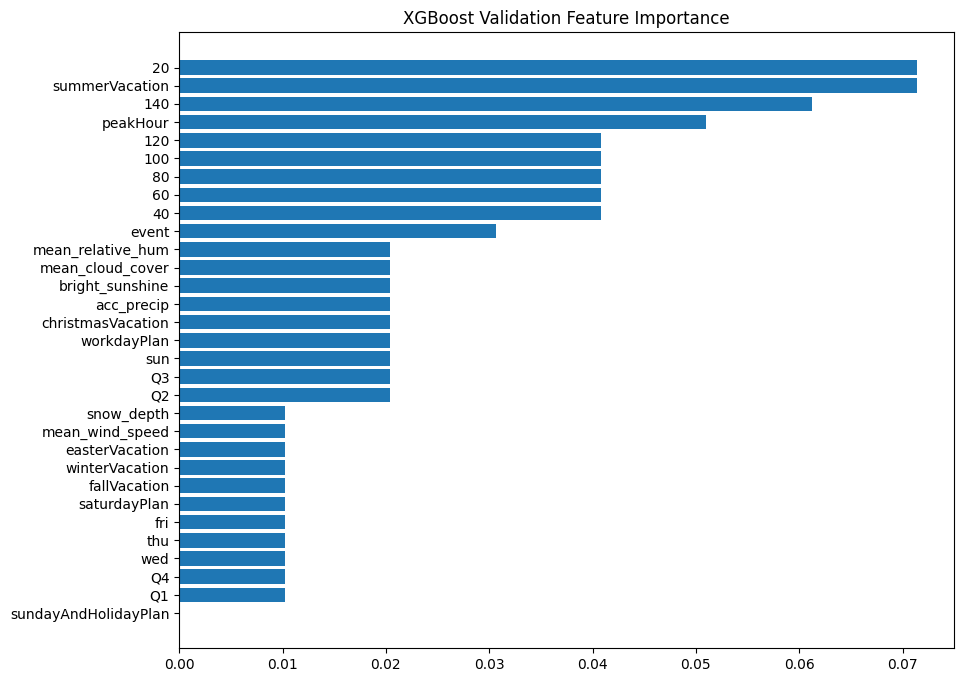

In [5]:
# XGBoost
laglist = [20, 40, 60, 80, 100, 120, 140]
model = XGBRegressor(n_estimators=50, alpha=0.1, eta=0.1, seed=42)

horizon = 40*agg
differentiation = None
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None
use_exog = True
interval = None

names_to_ignore = [Columns.calendar_fallVacation.value, Columns.calendar_easterVacation.value, Columns.calendar_summerVacation.value,
                   Columns.calendar_winterVacation.value, Columns.calendar_christmasVacation.value,
                   Columns.calendar_Q1.value, Columns.calendar_Q2.value, Columns.calendar_Q3.value, Columns.calendar_Q4.value,
                   Columns.calendar_workdayPlan.value, Columns.calendar_saturdayPlan.value, Columns.calendar_sundayAndHolidayPlan.value]

X_train_temp = copy(X_train)
X_val_temp = copy(X_val)
while True:
    # find feature importances
    _, fi_loco_val = utils.Sklearn.loco_feature_importance(X_train_temp, y_train, X_val_temp, y_val, 
                                            model, laglist, horizon, differentiation, 
                                            scalar, exog_scalar, window_type, window_size, use_exog, interval)
    # find low importance features
    feature_score_worst = 10000
    feature_name_worst = None
    for feature_name, feature_score in fi_loco_val.items():
        if feature_score < feature_score_worst and feature_name not in names_to_ignore:
            feature_score_worst = feature_score
            feature_name_worst = feature_name
    # stop if all are significant or drop features
    if feature_score_worst > 0.0:
        break
    else:
        # ensure that unused variables are not dropped
        X_train_temp = X_train_temp.drop(columns=feature_name_worst)
        X_val_temp = X_val_temp.drop(columns=feature_name_worst)
        print('Dropped feature:', feature_name_worst)

fi_loco_val

utils.tools.plotFeatureImportance(fi_loco_val, 'XGBoost')

# Performance based Shapley Values

In [9]:
import os
from anatomy import *

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def train_lasso(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    lasso_model = Lasso(alpha=0.005, fit_intercept=True, random_state=42)
    lasso_model.fit(x_train, y_train)

    def pred_fn_lasso(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(lasso_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_lasso)

def train_rf(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    rf_model = RandomForestRegressor(n_estimators=250, random_state=42)
    rf_model.fit(x_train, y_train)

    def pred_fn_rf(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(rf_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_rf)

def train_xgb(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    xgb_model = XGBRegressor(n_estimators=50, alpha=0.1, eta=0.1, seed=42)
    xgb_model.fit(x_train, y_train)

    def pred_fn_xgb(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(xgb_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_xgb)


def generate_data(n_predictors=3) -> [pd.DataFrame, AnatomySubsets]:
    xy = copy(pd.concat([X_train, X_val]))
    scalar = StandardScaler()
    xy = pd.DataFrame(scalar.fit_transform(xy), columns=xy.columns)

    xy['y'] = copy(pd.concat([y_train, y_val]))
    for i in [20, 40, 60, 80, 100, 120, 140]:
        xy[f'{i}'] = xy['y'].shift(periods=i).fillna(0)

    subsets = AnatomySubsets.generate(
        index=xy.index,
        initial_window=X_train.shape[0],
        estimation_type=AnatomySubsets.EstimationType.EXPANDING,
        periods=1,
        gap=0
    )

    return xy, subsets

## XGBoost

In [6]:
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["xgb"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=10).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyXGB.bin"
    )

def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyXGB.bin")
    groups = {
        "xgb": ["xgb"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    pd.options.display.width = 0  # to print all columns

    tmpl = "contributions to %s:"
    anatomized_mae = anatomize_mae()
    print(tmpl % "mean absolute error")
    print(anatomized_mae, "\n")
    return anatomized_mae


# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

estimate_anatomy(xy, subsets)
print('anatomy estimated')

# load anatomy bin and calculate shapley values
anatomized_mae_xgb = anatomize(xy, subsets)

data generated
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:    9.9s
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:   10.0s
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:   10.2s
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:   10.3s
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:   10.3s
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:   10.3s
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:   10.3s
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:   10.4s
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:   10.4s
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:   19.0s
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:   19.2s
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=11)]: Done  15 tasks   

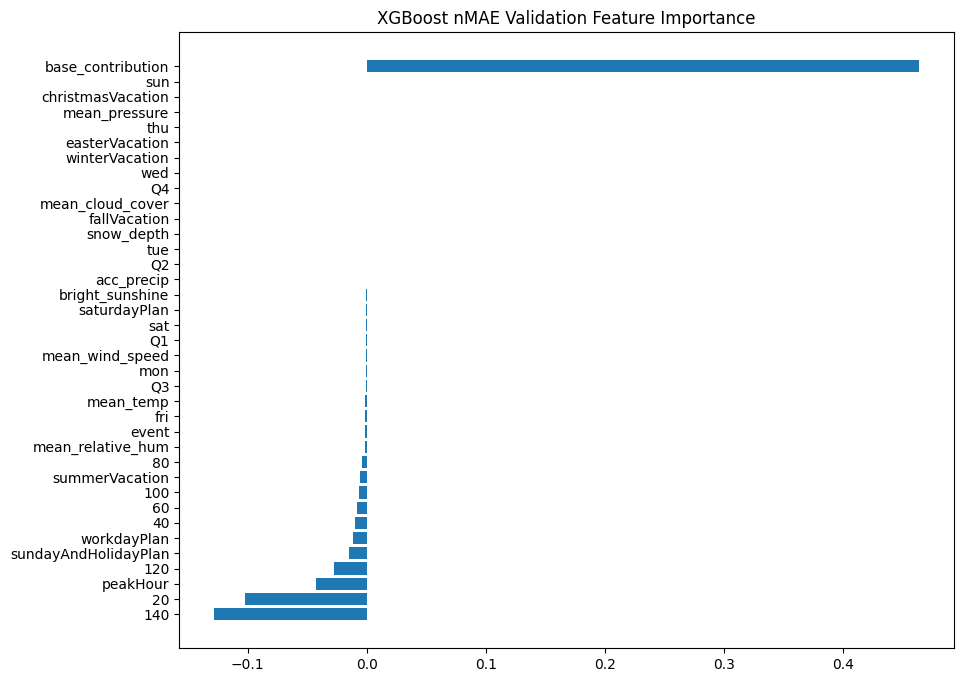

In [7]:
keys = anatomized_mae_xgb.transpose()['xgb']['14680 -> 16519'].index
values = anatomized_mae_xgb.transpose()['xgb']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'XGBoost nMAE')

In [13]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyXGB.bin")
    groups = {
        "xgb": ["xgb"]
    }

    def anatomize_raw() -> pd.DataFrame:
        def transform(y_hat):
            return y_hat

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    pd.options.display.width = 0  # to print all columns

    tmpl = "contributions to %s:"
    anatomized_raw = anatomize_raw()
    print(tmpl % "raw")
    print(anatomized_raw, "\n")
    return anatomized_raw


# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

# load anatomy bin and calculate shapley values
anatomized_raw_xgb = anatomize(xy, subsets)

data generated
contributions to raw:
           base_contribution   peakHour        Q1        Q2        Q3  \
xgb 14680         453.741180 -24.588271 -1.957915  0.188526 -2.260926   
    14681         453.717224 -46.819569 -1.812521 -0.085368 -1.395825   
    14682         453.692078 -42.979108 -1.583816  0.035181 -1.987787   
    14683         453.669281 -50.971004 -1.178540 -0.041476 -0.632718   
    14684         453.648590 -22.213264 -0.934038  0.054459 -0.356291   
...                      ...        ...       ...       ...       ...   
    16515         454.961212  -6.699190 -0.803033 -0.009874 -0.131230   
    16516         454.970612  -6.813199 -0.687074 -0.043512 -0.194182   
    16517         454.966309 -13.054462 -0.730751 -0.066249 -0.358148   
    16518         454.964722 -15.627817 -1.012709 -0.059004 -0.249667   
    16519         454.960876  -7.725136 -1.211140 -0.095422 -0.410631   

                 Q4       mon       tue       wed       thu  ...  \
xgb 14680  0.03383

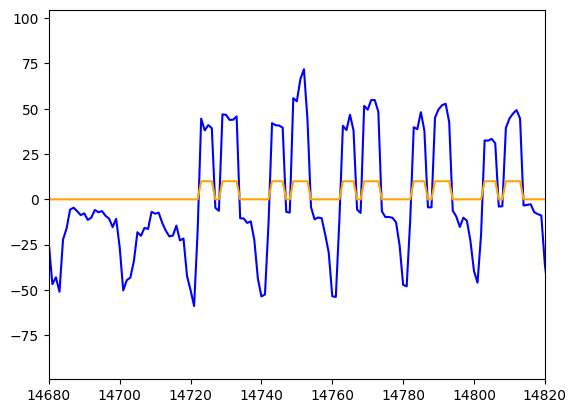

In [127]:
variable = Columns.calendar_peakHour
keys = anatomized_raw_xgb.loc['xgb'].index
values = anatomized_raw_xgb.loc['xgb'][variable.value]

plt.plot(keys, values, color='blue')
plt.plot(keys, 10*df_val[df_val['line'] == '1A'][variable.value].values, color='orange')
plt.xlim([14680, 14680+140])
plt.show()


#shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

#utils.tools.plotFeatureImportance(shapley_dict, 'XGBoost raw impact')

## Random Forest

In [5]:
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["rf"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=5).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyRF.bin"
    )

def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyRF.bin")
    groups = {
        "rf": ["rf"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    pd.options.display.width = 0  # to print all columns

    tmpl = "contributions to %s:"
    anatomized_mae = anatomize_mae()
    print(tmpl % "mean absolute error")
    print(anatomized_mae, "\n")
    return anatomized_mae


# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

estimate_anatomy(xy, subsets)
print('anatomy estimated')

# load anatomy bin and calculate shapley values
anatomized_mae_rf = anatomize(xy, subsets)

data generated
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done  15 tasks   

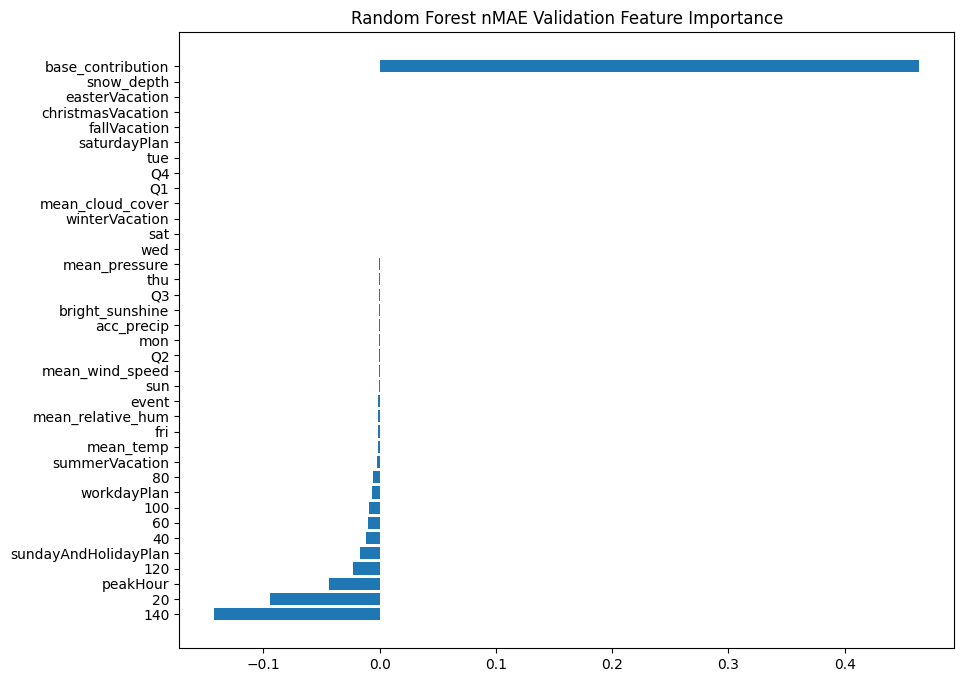

In [6]:
keys = anatomized_mae_rf.transpose()['rf']['14680 -> 16519'].index
values = anatomized_mae_rf.transpose()['rf']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'Random Forest nMAE')

## Lasso

In [4]:
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["lasso"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=10).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyLasso.bin"
    )

def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyLasso.bin")
    groups = {
        "lasso": ["lasso"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    pd.options.display.width = 0  # to print all columns

    tmpl = "contributions to %s:"
    anatomized_mae = anatomize_mae()
    print(tmpl % "mean absolute error")
    print(anatomized_mae, "\n")
    return anatomized_mae


# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

estimate_anatomy(xy, subsets)
print('anatomy estimated')

# load anatomy bin and calculate shapley values
anatomized_mae_lasso = anatomize(xy, subsets)

data generated
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.054e+06, tolerance: 1.089e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.053e+06, tolerance: 1.089e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:    3.5s
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:    3.7s
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:    3.7s
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:    3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e+06, tolerance: 1.089e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e+06, tolerance: 1.089e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:    6.0s
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=11)]: Done  15 tasks      | elapsed:    6.0s
[Parallel(n_jobs=11)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=11)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=11)]: Done  18 tasks      | elapsed:    6.1s
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    6.1s
[Parallel(n_jobs=11)]: Done  20 tasks      | elapsed:    6.2s
[Parallel(n_jobs=11)]: Done  21 tasks      | elapsed:    6.2s
[Parallel(n_jobs=11)]: Done  22 tasks      | elapsed:    6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.048e+06, tolerance: 1.090e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.049e+06, tolerance: 1.090e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  23 tasks      | elapsed:    8.2s
[Parallel(n_jobs=11)]: Done  24 tasks      | elapsed:    8.3s
[Parallel(n_jobs=11)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=11)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=11)]: Done  27 tasks      | elapsed:    8.5s
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    8.6s
[Parallel(n_jobs=11)]: Done  29 tasks      | elapsed:    8.6s
[Parallel(n_jobs=11)]: Done  30 tasks      | elapsed:    8.6s
[Parallel(n_jobs=11)]: Done  31 tasks      | elapsed:    8.6s
[Parallel(n_jobs=11)]: Done  32 tasks      | elapsed:    8.7s
[Parallel(n_jobs=11)]: Done  33 tasks      | elapsed:    8.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.048e+06, tolerance: 1.090e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+06, tolerance: 1.090e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=11)]: Done  35 tasks      | elapsed:   10.6s
[Parallel(n_jobs=11)]: Done  36 tasks      | elapsed:   10.7s
[Parallel(n_jobs=11)]: Done  37 tasks      | elapsed:   10.8s
[Parallel(n_jobs=11)]: Done  38 tasks      | elapsed:   10.9s
[Parallel(n_jobs=11)]: Done  39 tasks      | elapsed:   10.9s
[Parallel(n_jobs=11)]: Done  40 tasks      | elapsed:   11.0s
[Parallel(n_jobs=11)]: Done  41 tasks      | elapsed:   11.0s
[Parallel(n_jobs=11)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=11)]: Done  43 tasks      | elapsed:   11.1s
[Parallel(n_jobs=11)]: Done  44 tasks      | elapsed:   11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.053e+06, tolerance: 1.091e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e+06, tolerance: 1.091e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  45 tasks      | elapsed:   13.0s
[Parallel(n_jobs=11)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=11)]: Done  47 tasks      | elapsed:   13.2s
[Parallel(n_jobs=11)]: Done  48 tasks      | elapsed:   13.2s
[Parallel(n_jobs=11)]: Done  49 tasks      | elapsed:   13.3s
[Parallel(n_jobs=11)]: Done  50 tasks      | elapsed:   13.3s
[Parallel(n_jobs=11)]: Done  51 tasks      | elapsed:   13.4s
[Parallel(n_jobs=11)]: Done  52 tasks      | elapsed:   13.4s
[Parallel(n_jobs=11)]: Done  53 tasks      | elapsed:   13.5s
[Parallel(n_jobs=11)]: Done  54 tasks      | elapsed:   13.5s
[Parallel(n_jobs=11)]: Done  55 tasks      | elapsed:   13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.071e+06, tolerance: 1.091e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+06, tolerance: 1.091e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  56 tasks      | elapsed:   15.5s
[Parallel(n_jobs=11)]: Done  57 tasks      | elapsed:   15.6s
[Parallel(n_jobs=11)]: Done  58 tasks      | elapsed:   15.6s
[Parallel(n_jobs=11)]: Done  59 tasks      | elapsed:   15.7s
[Parallel(n_jobs=11)]: Done  60 tasks      | elapsed:   15.7s
[Parallel(n_jobs=11)]: Done  61 tasks      | elapsed:   15.7s
[Parallel(n_jobs=11)]: Done  62 tasks      | elapsed:   15.8s
[Parallel(n_jobs=11)]: Done  63 tasks      | elapsed:   15.8s
[Parallel(n_jobs=11)]: Done  64 tasks      | elapsed:   15.9s
[Parallel(n_jobs=11)]: Done  65 tasks      | elapsed:   16.0s
[Parallel(n_jobs=11)]: Done  66 tasks      | elapsed:   16.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e+06, tolerance: 1.092e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+06, tolerance: 1.092e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  67 tasks      | elapsed:   17.8s
[Parallel(n_jobs=11)]: Done  68 tasks      | elapsed:   17.9s
[Parallel(n_jobs=11)]: Done  69 tasks      | elapsed:   17.9s
[Parallel(n_jobs=11)]: Done  70 tasks      | elapsed:   18.0s
[Parallel(n_jobs=11)]: Done  71 tasks      | elapsed:   18.0s
[Parallel(n_jobs=11)]: Done  72 tasks      | elapsed:   18.0s
[Parallel(n_jobs=11)]: Done  73 tasks      | elapsed:   18.1s
[Parallel(n_jobs=11)]: Done  74 tasks      | elapsed:   18.1s
[Parallel(n_jobs=11)]: Done  75 tasks      | elapsed:   18.2s
[Parallel(n_jobs=11)]: Done  76 tasks      | elapsed:   18.4s
[Parallel(n_jobs=11)]: Done  77 tasks      | elapsed:   18.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+06, tolerance: 1.092e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.076e+06, tolerance: 1.092e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  78 tasks      | elapsed:   20.2s
[Parallel(n_jobs=11)]: Done  79 tasks      | elapsed:   20.2s
[Parallel(n_jobs=11)]: Done  80 tasks      | elapsed:   20.3s
[Parallel(n_jobs=11)]: Done  81 tasks      | elapsed:   20.3s
[Parallel(n_jobs=11)]: Done  82 tasks      | elapsed:   20.3s
[Parallel(n_jobs=11)]: Done  83 tasks      | elapsed:   20.4s
[Parallel(n_jobs=11)]: Done  84 tasks      | elapsed:   20.4s
[Parallel(n_jobs=11)]: Done  85 tasks      | elapsed:   20.4s
[Parallel(n_jobs=11)]: Done  86 tasks      | elapsed:   20.5s
[Parallel(n_jobs=11)]: Done  87 tasks      | elapsed:   20.7s
[Parallel(n_jobs=11)]: Done  88 tasks      | elapsed:   20.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+06, tolerance: 1.093e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+06, tolerance: 1.093e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  89 tasks      | elapsed:   22.4s
[Parallel(n_jobs=11)]: Done  90 tasks      | elapsed:   22.4s
[Parallel(n_jobs=11)]: Done  91 tasks      | elapsed:   22.5s
[Parallel(n_jobs=11)]: Done  92 tasks      | elapsed:   22.5s
[Parallel(n_jobs=11)]: Done  93 tasks      | elapsed:   22.6s
[Parallel(n_jobs=11)]: Done  94 tasks      | elapsed:   22.7s
[Parallel(n_jobs=11)]: Done  95 tasks      | elapsed:   22.7s
[Parallel(n_jobs=11)]: Done  96 tasks      | elapsed:   22.7s
[Parallel(n_jobs=11)]: Done  97 tasks      | elapsed:   22.8s
[Parallel(n_jobs=11)]: Done  98 tasks      | elapsed:   22.9s
[Parallel(n_jobs=11)]: Done  99 tasks      | elapsed:   23.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+06, tolerance: 1.093e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+06, tolerance: 1.093e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 100 tasks      | elapsed:   24.6s
[Parallel(n_jobs=11)]: Done 101 tasks      | elapsed:   24.7s
[Parallel(n_jobs=11)]: Done 102 tasks      | elapsed:   24.7s
[Parallel(n_jobs=11)]: Done 103 tasks      | elapsed:   24.8s
[Parallel(n_jobs=11)]: Done 104 tasks      | elapsed:   24.8s
[Parallel(n_jobs=11)]: Done 105 tasks      | elapsed:   25.0s
[Parallel(n_jobs=11)]: Done 106 tasks      | elapsed:   25.0s
[Parallel(n_jobs=11)]: Done 107 tasks      | elapsed:   25.0s
[Parallel(n_jobs=11)]: Done 108 tasks      | elapsed:   25.1s
[Parallel(n_jobs=11)]: Done 109 tasks      | elapsed:   25.2s
[Parallel(n_jobs=11)]: Done 110 tasks      | elapsed:   25.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+06, tolerance: 1.093e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+06, tolerance: 1.093e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 111 tasks      | elapsed:   26.9s
[Parallel(n_jobs=11)]: Done 112 tasks      | elapsed:   27.0s
[Parallel(n_jobs=11)]: Done 113 tasks      | elapsed:   27.0s
[Parallel(n_jobs=11)]: Done 114 tasks      | elapsed:   27.0s
[Parallel(n_jobs=11)]: Done 115 tasks      | elapsed:   27.1s
[Parallel(n_jobs=11)]: Done 116 tasks      | elapsed:   27.2s
[Parallel(n_jobs=11)]: Done 117 tasks      | elapsed:   27.2s
[Parallel(n_jobs=11)]: Done 118 tasks      | elapsed:   27.3s
[Parallel(n_jobs=11)]: Done 119 tasks      | elapsed:   27.4s
[Parallel(n_jobs=11)]: Done 120 tasks      | elapsed:   27.5s
[Parallel(n_jobs=11)]: Done 121 tasks      | elapsed:   27.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+06, tolerance: 1.094e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+06, tolerance: 1.094e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 122 tasks      | elapsed:   29.1s
[Parallel(n_jobs=11)]: Done 123 tasks      | elapsed:   29.2s
[Parallel(n_jobs=11)]: Done 124 tasks      | elapsed:   29.2s
[Parallel(n_jobs=11)]: Done 125 tasks      | elapsed:   29.3s
[Parallel(n_jobs=11)]: Done 126 tasks      | elapsed:   29.4s
[Parallel(n_jobs=11)]: Done 127 tasks      | elapsed:   29.4s
[Parallel(n_jobs=11)]: Done 128 tasks      | elapsed:   29.5s
[Parallel(n_jobs=11)]: Done 129 tasks      | elapsed:   29.7s
[Parallel(n_jobs=11)]: Done 130 tasks      | elapsed:   29.7s
[Parallel(n_jobs=11)]: Done 131 tasks      | elapsed:   29.8s
[Parallel(n_jobs=11)]: Done 132 tasks      | elapsed:   29.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+06, tolerance: 1.094e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+06, tolerance: 1.094e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 133 tasks      | elapsed:   31.5s
[Parallel(n_jobs=11)]: Done 134 tasks      | elapsed:   31.5s
[Parallel(n_jobs=11)]: Done 135 tasks      | elapsed:   31.5s
[Parallel(n_jobs=11)]: Done 136 tasks      | elapsed:   31.6s
[Parallel(n_jobs=11)]: Done 137 tasks      | elapsed:   31.6s
[Parallel(n_jobs=11)]: Done 138 tasks      | elapsed:   31.7s
[Parallel(n_jobs=11)]: Done 139 tasks      | elapsed:   31.8s
[Parallel(n_jobs=11)]: Done 140 tasks      | elapsed:   31.9s
[Parallel(n_jobs=11)]: Done 141 tasks      | elapsed:   31.9s
[Parallel(n_jobs=11)]: Done 142 tasks      | elapsed:   32.0s
[Parallel(n_jobs=11)]: Done 143 tasks      | elapsed:   32.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e+06, tolerance: 1.095e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e+06, tolerance: 1.095e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 144 tasks      | elapsed:   33.8s
[Parallel(n_jobs=11)]: Done 145 tasks      | elapsed:   33.8s
[Parallel(n_jobs=11)]: Done 146 tasks      | elapsed:   33.9s
[Parallel(n_jobs=11)]: Done 147 tasks      | elapsed:   33.9s
[Parallel(n_jobs=11)]: Done 148 tasks      | elapsed:   33.9s
[Parallel(n_jobs=11)]: Done 149 tasks      | elapsed:   34.1s
[Parallel(n_jobs=11)]: Done 150 tasks      | elapsed:   34.2s
[Parallel(n_jobs=11)]: Done 151 tasks      | elapsed:   34.2s
[Parallel(n_jobs=11)]: Done 152 tasks      | elapsed:   34.3s
[Parallel(n_jobs=11)]: Done 153 tasks      | elapsed:   34.3s
[Parallel(n_jobs=11)]: Done 154 tasks      | elapsed:   34.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e+06, tolerance: 1.095e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.061e+06, tolerance: 1.095e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 155 tasks      | elapsed:   36.5s
[Parallel(n_jobs=11)]: Done 156 tasks      | elapsed:   36.6s
[Parallel(n_jobs=11)]: Done 157 tasks      | elapsed:   36.6s
[Parallel(n_jobs=11)]: Done 158 tasks      | elapsed:   36.7s
[Parallel(n_jobs=11)]: Done 159 tasks      | elapsed:   36.9s
[Parallel(n_jobs=11)]: Done 160 tasks      | elapsed:   37.1s
[Parallel(n_jobs=11)]: Done 161 tasks      | elapsed:   37.1s
[Parallel(n_jobs=11)]: Done 162 tasks      | elapsed:   37.2s
[Parallel(n_jobs=11)]: Done 163 tasks      | elapsed:   37.2s
[Parallel(n_jobs=11)]: Done 164 tasks      | elapsed:   37.3s
[Parallel(n_jobs=11)]: Done 165 tasks      | elapsed:   37.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 166 tasks      | elapsed:   39.7s
[Parallel(n_jobs=11)]: Done 167 tasks      | elapsed:   39.7s
[Parallel(n_jobs=11)]: Done 168 tasks      | elapsed:   39.9s
[Parallel(n_jobs=11)]: Done 169 tasks      | elapsed:   39.9s
[Parallel(n_jobs=11)]: Done 170 tasks      | elapsed:   40.0s
[Parallel(n_jobs=11)]: Done 171 tasks      | elapsed:   40.1s
[Parallel(n_jobs=11)]: Done 172 tasks      | elapsed:   40.1s
[Parallel(n_jobs=11)]: Done 173 tasks      | elapsed:   40.1s
[Parallel(n_jobs=11)]: Done 174 tasks      | elapsed:   40.2s
[Parallel(n_jobs=11)]: Done 175 tasks      | elapsed:   40.2s
[Parallel(n_jobs=11)]: Done 176 tasks      | elapsed:   40.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.056e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.056e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 177 tasks      | elapsed:   42.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:   42.2s
[Parallel(n_jobs=11)]: Done 179 tasks      | elapsed:   42.3s
[Parallel(n_jobs=11)]: Done 180 tasks      | elapsed:   42.3s
[Parallel(n_jobs=11)]: Done 181 tasks      | elapsed:   42.3s
[Parallel(n_jobs=11)]: Done 182 tasks      | elapsed:   42.4s
[Parallel(n_jobs=11)]: Done 183 tasks      | elapsed:   42.5s
[Parallel(n_jobs=11)]: Done 184 tasks      | elapsed:   42.5s
[Parallel(n_jobs=11)]: Done 185 tasks      | elapsed:   42.5s
[Parallel(n_jobs=11)]: Done 186 tasks      | elapsed:   42.6s
[Parallel(n_jobs=11)]: Done 187 tasks      | elapsed:   42.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 188 tasks      | elapsed:   44.3s
[Parallel(n_jobs=11)]: Done 189 tasks      | elapsed:   44.6s
[Parallel(n_jobs=11)]: Done 190 tasks      | elapsed:   44.6s
[Parallel(n_jobs=11)]: Done 191 tasks      | elapsed:   44.6s
[Parallel(n_jobs=11)]: Done 192 tasks      | elapsed:   44.7s
[Parallel(n_jobs=11)]: Done 193 tasks      | elapsed:   44.7s
[Parallel(n_jobs=11)]: Done 194 tasks      | elapsed:   44.8s
[Parallel(n_jobs=11)]: Done 195 tasks      | elapsed:   44.8s
[Parallel(n_jobs=11)]: Done 196 tasks      | elapsed:   44.8s
[Parallel(n_jobs=11)]: Done 197 tasks      | elapsed:   44.9s
[Parallel(n_jobs=11)]: Done 198 tasks      | elapsed:   44.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.097e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+06, tolerance: 1.097e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 199 tasks      | elapsed:   46.6s
[Parallel(n_jobs=11)]: Done 200 tasks      | elapsed:   47.0s
[Parallel(n_jobs=11)]: Done 201 tasks      | elapsed:   47.0s
[Parallel(n_jobs=11)]: Done 202 tasks      | elapsed:   47.1s
[Parallel(n_jobs=11)]: Done 203 tasks      | elapsed:   47.2s
[Parallel(n_jobs=11)]: Done 204 tasks      | elapsed:   47.2s
[Parallel(n_jobs=11)]: Done 205 tasks      | elapsed:   47.3s
[Parallel(n_jobs=11)]: Done 206 tasks      | elapsed:   47.3s
[Parallel(n_jobs=11)]: Done 207 tasks      | elapsed:   47.3s
[Parallel(n_jobs=11)]: Done 208 tasks      | elapsed:   47.4s
[Parallel(n_jobs=11)]: Done 209 tasks      | elapsed:   47.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.097e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.097e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 210 tasks      | elapsed:   49.0s
[Parallel(n_jobs=11)]: Done 211 tasks      | elapsed:   49.3s
[Parallel(n_jobs=11)]: Done 212 tasks      | elapsed:   49.3s
[Parallel(n_jobs=11)]: Done 213 tasks      | elapsed:   49.4s
[Parallel(n_jobs=11)]: Done 214 tasks      | elapsed:   49.6s
[Parallel(n_jobs=11)]: Done 215 tasks      | elapsed:   49.6s
[Parallel(n_jobs=11)]: Done 216 tasks      | elapsed:   49.6s
[Parallel(n_jobs=11)]: Done 217 tasks      | elapsed:   49.7s
[Parallel(n_jobs=11)]: Done 218 tasks      | elapsed:   49.7s
[Parallel(n_jobs=11)]: Done 219 tasks      | elapsed:   49.8s
[Parallel(n_jobs=11)]: Done 220 tasks      | elapsed:   49.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.097e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.098e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 221 tasks      | elapsed:   51.3s
[Parallel(n_jobs=11)]: Done 222 tasks      | elapsed:   51.6s
[Parallel(n_jobs=11)]: Done 223 tasks      | elapsed:   51.6s
[Parallel(n_jobs=11)]: Done 224 tasks      | elapsed:   51.7s
[Parallel(n_jobs=11)]: Done 225 tasks      | elapsed:   52.0s
[Parallel(n_jobs=11)]: Done 226 tasks      | elapsed:   52.0s
[Parallel(n_jobs=11)]: Done 227 tasks      | elapsed:   52.0s
[Parallel(n_jobs=11)]: Done 228 tasks      | elapsed:   52.1s
[Parallel(n_jobs=11)]: Done 229 tasks      | elapsed:   52.1s
[Parallel(n_jobs=11)]: Done 230 tasks      | elapsed:   52.2s
[Parallel(n_jobs=11)]: Done 231 tasks      | elapsed:   52.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.098e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.098e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 232 tasks      | elapsed:   53.5s
[Parallel(n_jobs=11)]: Done 233 tasks      | elapsed:   53.8s
[Parallel(n_jobs=11)]: Done 234 tasks      | elapsed:   53.8s
[Parallel(n_jobs=11)]: Done 235 tasks      | elapsed:   53.9s
[Parallel(n_jobs=11)]: Done 236 tasks      | elapsed:   54.4s
[Parallel(n_jobs=11)]: Done 237 tasks      | elapsed:   54.4s
[Parallel(n_jobs=11)]: Done 238 tasks      | elapsed:   54.4s
[Parallel(n_jobs=11)]: Done 239 tasks      | elapsed:   54.4s
[Parallel(n_jobs=11)]: Done 240 tasks      | elapsed:   54.5s
[Parallel(n_jobs=11)]: Done 241 tasks      | elapsed:   54.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.098e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 242 tasks      | elapsed:   54.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e+06, tolerance: 1.098e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e+06, tolerance: 1.098e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 243 tasks      | elapsed:   55.7s
[Parallel(n_jobs=11)]: Done 244 tasks      | elapsed:   56.3s
[Parallel(n_jobs=11)]: Done 245 tasks      | elapsed:   56.3s
[Parallel(n_jobs=11)]: Done 246 tasks      | elapsed:   56.4s
[Parallel(n_jobs=11)]: Done 247 tasks      | elapsed:   56.7s
[Parallel(n_jobs=11)]: Done 248 tasks      | elapsed:   56.8s
[Parallel(n_jobs=11)]: Done 249 tasks      | elapsed:   56.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.080e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 250 tasks      | elapsed:   56.9s
[Parallel(n_jobs=11)]: Done 251 tasks      | elapsed:   56.9s
[Parallel(n_jobs=11)]: Done 252 tasks      | elapsed:   57.2s
[Parallel(n_jobs=11)]: Done 253 tasks      | elapsed:   57.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.080e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.080e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 254 tasks      | elapsed:   58.2s
[Parallel(n_jobs=11)]: Done 255 tasks      | elapsed:   58.7s
[Parallel(n_jobs=11)]: Done 256 tasks      | elapsed:   58.8s
[Parallel(n_jobs=11)]: Done 257 tasks      | elapsed:   58.8s
[Parallel(n_jobs=11)]: Done 258 tasks      | elapsed:   59.1s
[Parallel(n_jobs=11)]: Done 259 tasks      | elapsed:   59.2s
[Parallel(n_jobs=11)]: Done 260 tasks      | elapsed:   59.2s
[Parallel(n_jobs=11)]: Done 261 tasks      | elapsed:   59.3s
[Parallel(n_jobs=11)]: Done 262 tasks      | elapsed:   59.4s
[Parallel(n_jobs=11)]: Done 263 tasks      | elapsed:   59.5s
[Parallel(n_jobs=11)]: Done 264 tasks      | elapsed:   59.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 265 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 266 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 267 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 268 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 269 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 270 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 271 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 273 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 274 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 275 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+06, tolerance: 1.099e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 277 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 278 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 279 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 281 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 283 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 284 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 285 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 286 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 287 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 288 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 289 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 290 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 291 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 292 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 293 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 294 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 295 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 296 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 297 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+06, tolerance: 1.100e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 298 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 299 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 300 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 301 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 302 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 303 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 304 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 305 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 306 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 307 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 308 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 309 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 310 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 311 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 312 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 313 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 314 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 315 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 316 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 317 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 318 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 319 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 320 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.081e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 321 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 322 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 323 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 324 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 325 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 326 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 327 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 328 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 329 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 330 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 331 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 332 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 333 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 334 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 335 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 336 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 337 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 338 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 339 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 340 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 341 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 342 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 343 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 344 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 345 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 346 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 347 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 348 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 349 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 350 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 351 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 352 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.102e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 353 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 354 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 355 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 356 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 358 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 359 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 360 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 361 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 362 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 363 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 364 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 365 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 366 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 367 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 368 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 369 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 370 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 371 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 372 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 373 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 374 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 375 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.103e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 376 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 377 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 378 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 379 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 380 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 381 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 382 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 383 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 384 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 385 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 386 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 387 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 388 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 390 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 391 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 392 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 393 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 394 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 395 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 396 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 397 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 398 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 399 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 400 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 401 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 402 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 403 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 404 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 405 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 406 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 407 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 408 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 409 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 410 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 411 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 412 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 413 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 414 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 415 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 417 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 418 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 419 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 420 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 421 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 422 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 423 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 424 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 425 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 427 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 429 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 430 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 431 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 432 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 433 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 434 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.105e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 435 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 436 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 437 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 438 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 439 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 440 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 441 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 442 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 443 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 444 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 445 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 446 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 447 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 448 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 449 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 450 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 451 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 452 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 453 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 454 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e+06, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 455 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 456 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 457 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.089e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 458 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 459 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 460 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 461 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 462 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 463 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 464 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 465 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 466 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 467 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 468 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 469 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 470 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 471 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 472 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 473 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 474 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 475 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 476 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+06, tolerance: 1.107e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 477 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 478 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 479 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 480 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 481 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 482 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 483 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 484 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 485 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 486 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 487 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 488 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 489 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 490 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 491 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 492 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 493 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 494 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 495 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 496 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 497 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 498 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 499 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 500 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 501 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 502 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 503 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 504 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 505 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 506 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 507 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 508 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 509 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 510 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 511 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 512 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 513 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 514 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 515 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 516 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 517 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 518 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 519 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 520 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 521 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 522 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 523 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 524 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 525 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 526 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 527 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 528 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 529 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 530 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 531 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 532 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 533 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 534 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 535 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 536 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 537 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.109e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 538 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 539 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 540 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 541 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 542 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 543 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 544 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 545 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 546 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 547 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 548 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 549 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 550 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 551 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 552 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 553 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 554 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 555 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 556 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 557 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 558 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 559 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 560 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 561 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 562 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 563 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 564 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 565 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 566 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 567 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 568 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 569 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 570 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 571 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 572 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 573 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 574 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 575 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+06, tolerance: 1.110e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 576 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 577 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 578 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 579 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 580 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 581 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 582 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 583 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 584 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 585 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 586 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 587 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 588 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 589 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 590 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 591 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 592 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 593 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+06, tolerance: 1.111e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 594 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 595 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 596 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 597 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 598 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 599 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 600 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 601 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 602 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 603 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 604 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 605 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 606 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 607 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 608 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 609 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 610 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.116e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 611 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 612 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 613 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 614 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 615 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e+06, tolerance: 1.112e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 616 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 617 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 618 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 619 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 620 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 621 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 622 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 623 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 624 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 625 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 626 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 627 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 628 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 629 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 630 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 631 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 633 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 634 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 635 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 636 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 637 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 638 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 639 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 640 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 641 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 642 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 643 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 644 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 645 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.113e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 646 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 647 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 648 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 649 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 650 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 651 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 652 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 653 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 654 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 655 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.116e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 656 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 657 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.116e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 658 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.116e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 659 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 660 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 661 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 662 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 663 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 664 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 665 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 666 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 667 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 668 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 669 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 670 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 671 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 672 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 673 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+06, tolerance: 1.114e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 674 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 675 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 676 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 677 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 678 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 679 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 680 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 681 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 682 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 683 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 684 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 685 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 686 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 687 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 688 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 689 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 690 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 691 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 692 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 693 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 694 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 695 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.115e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 696 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 697 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 698 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 699 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 700 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 701 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 702 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 703 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 704 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 705 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 706 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 707 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 708 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 709 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 710 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 711 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 712 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 713 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 714 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 715 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 716 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 717 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e+06, tolerance: 1.116e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 718 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 719 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 720 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 721 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 722 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 723 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 724 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 725 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 726 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 727 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 728 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 729 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 730 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 731 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 732 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 733 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 734 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 735 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 736 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 737 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 738 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 739 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 740 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 741 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 742 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 743 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 744 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 745 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+06, tolerance: 1.117e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 746 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 747 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 748 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 749 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 750 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 751 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 752 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 753 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 754 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 755 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 756 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 757 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 758 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 759 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 760 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 761 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 762 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 763 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 764 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 765 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 766 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 767 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 768 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.119e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 769 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 770 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 771 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 772 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 773 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 774 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 775 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 776 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 777 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 779 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 780 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 781 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 782 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.120e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 783 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 785 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 786 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 787 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 788 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 789 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 790 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 791 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 792 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 793 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 794 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+06, tolerance: 1.121e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 795 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 796 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 797 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 798 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 799 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 800 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 801 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 802 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 803 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 804 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.122e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 805 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 806 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 807 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 808 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 809 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 810 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 811 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 812 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 813 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 814 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 815 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 816 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 817 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 818 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 819 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 820 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 821 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 822 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 823 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 824 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.123e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 825 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 826 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 827 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 828 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 829 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 830 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 831 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 832 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 833 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 834 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 835 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 836 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 837 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 838 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 839 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 840 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 841 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 842 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 843 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 844 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 845 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 846 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 847 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 848 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 849 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 850 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 851 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 852 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 853 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 854 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 855 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 856 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 857 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 858 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 859 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.132e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.132e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 860 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 861 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 862 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 863 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 864 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.132e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 865 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 866 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 867 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 868 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 869 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 870 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 871 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 872 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 873 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 874 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 875 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 876 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 877 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 878 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 879 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 880 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 881 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 882 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 883 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 884 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.145e+06, tolerance: 1.126e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 885 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 886 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.147e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 887 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 888 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 889 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 890 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 891 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 892 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.160e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 893 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 894 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 895 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 896 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 897 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 898 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 899 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 900 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 901 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 902 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 903 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 904 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 905 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.128e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 906 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 907 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 908 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 909 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 910 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 911 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 912 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 913 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 914 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 915 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 916 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 917 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 918 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 919 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+06, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 920 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 921 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 922 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 923 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 924 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 925 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 926 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 927 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 928 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 929 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 930 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 931 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 932 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.160e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.160e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 933 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 934 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 935 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 936 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 937 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 938 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 939 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 940 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 941 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 942 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 943 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 944 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+06, tolerance: 1.131e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 945 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 946 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 947 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 948 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 949 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 950 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 951 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 952 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 953 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 954 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 955 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 956 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 957 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 958 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 959 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 960 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 961 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+06, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 962 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 963 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 964 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 965 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+06, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+06, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 966 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 967 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 968 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 969 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 970 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 971 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 972 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 973 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 974 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 975 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 976 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 977 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 978 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 979 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 980 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 981 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 982 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 983 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+06, tolerance: 1.134e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 984 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 985 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 986 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 987 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 988 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 989 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 990 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 991 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 992 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 993 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 994 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 995 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 996 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 997 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 998 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 999 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1000 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1001 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1002 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1003 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1004 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1005 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1006 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1007 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1008 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1009 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1010 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1011 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1012 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1013 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.148e+06, tolerance: 1.135e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1014 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1015 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.148e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1016 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1017 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 1018 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1019 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1020 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1021 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1022 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1023 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1024 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1025 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1026 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.167e+06, tolerance: 1.136e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1027 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1028 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1029 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1030 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1031 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1032 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1033 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1034 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1035 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.183e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.183e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1036 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1037 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.137e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1038 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1039 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1040 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.138e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.138e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1041 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1042 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.138e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.138e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1043 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 1044 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1045 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1046 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1047 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+06, tolerance: 1.138e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1048 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1049 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1050 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1051 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1052 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1053 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1054 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1055 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1056 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1057 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+06, tolerance: 1.139e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1058 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1059 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+06, tolerance: 1.140e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+06, tolerance: 1.140e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1060 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1061 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+06, tolerance: 1.140e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1062 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.140e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1063 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1064 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.140e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.140e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1065 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1066 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1067 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1068 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1069 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 1070 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1071 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1072 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1073 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1074 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1075 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.176e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1076 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1077 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.176e+06, tolerance: 1.141e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.176e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1078 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1079 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.176e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1080 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1081 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1082 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1083 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1084 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1085 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1086 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1087 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1088 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1089 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1090 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1091 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1092 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1093 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1094 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1095 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1096 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 1097 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.143e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1098 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1099 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1100 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1101 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1102 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1103 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1104 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1105 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1106 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.145e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.145e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1107 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1108 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.145e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1109 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.145e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.145e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1110 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1111 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1112 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1113 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1114 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1115 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1116 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1117 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1118 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 1119 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.176e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1120 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.176e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1121 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1122 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1123 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1124 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1125 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1126 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1127 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1128 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1129 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.146e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1130 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1131 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1132 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1133 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1134 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1135 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1136 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1137 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1138 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1139 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1140 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1141 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 1142 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1143 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+06, tolerance: 1.147e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1144 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1145 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1147 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1148 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1149 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1150 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.183e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1151 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1152 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1153 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1154 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.186e+06, tolerance: 1.148e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1155 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1156 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1157 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1158 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.195e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1159 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1160 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.196e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1161 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1162 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.200e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1163 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1164 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.204e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.206e+06, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1165 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.207e+06, tolerance: 1.150e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+06, tolerance: 1.150e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1166 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1167 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.214e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.212e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1168 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1169 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 1170 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1171 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1172 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1173 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1174 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1175 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1177 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+06, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1178 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1179 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1180 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1181 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1182 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1183 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1184 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1185 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1186 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1187 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.152e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1188 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.153e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1189 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1190 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.153e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.153e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1191 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 1192 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.153e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1193 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+06, tolerance: 1.153e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+06, tolerance: 1.153e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1195 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1197 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1198 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1199 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1200 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1201 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1202 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1203 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1204 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1205 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.154e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1206 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1207 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1208 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1209 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1210 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1211 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1212 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1213 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1214 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.155e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1215 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1216 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1217 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.156e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.156e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1218 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1219 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1220 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.156e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.157e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1221 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e+06, tolerance: 1.157e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1222 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.157e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.157e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1223 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1224 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1225 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.157e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1226 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.158e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1227 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.158e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.159e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1229 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1230 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1231 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.159e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.159e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1232 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.159e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1233 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.159e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+06, tolerance: 1.159e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1234 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1235 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1236 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1237 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1238 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1239 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1240 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1241 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1242 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1243 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.160e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1244 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1245 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.161e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.162e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1246 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1247 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1248 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1249 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.162e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1250 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1251 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1252 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1253 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1254 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1255 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1256 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+06, tolerance: 1.163e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1257 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1258 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1259 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1260 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.164e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1261 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.164e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.164e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1262 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1263 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1264 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.164e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.164e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1265 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1266 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1267 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1268 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1269 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1270 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1271 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1272 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1273 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1274 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1275 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1276 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1277 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1278 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1279 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1280 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1281 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1282 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1283 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1284 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1285 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1286 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1287 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1288 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1289 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1290 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1291 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1292 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1293 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1294 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e+06, tolerance: 1.166e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1295 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1296 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1297 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.233e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1298 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1299 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1300 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1301 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1302 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.242e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.244e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1303 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1304 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1305 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.246e+06, tolerance: 1.167e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.247e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1306 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1307 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.251e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1308 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1309 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1310 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1311 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1312 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1313 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1314 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1315 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1316 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1317 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1318 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1319 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1320 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1321 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1322 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1323 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+06, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1324 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1325 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.260e+06, tolerance: 1.170e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.260e+06, tolerance: 1.170e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1326 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1327 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.260e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.260e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1328 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1329 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1330 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1331 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1332 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1333 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1334 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1335 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1336 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.171e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1337 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1338 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1339 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1340 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1341 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1342 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1343 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1344 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1345 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.172e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1346 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1347 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1348 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1349 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1350 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1351 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1352 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1353 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1354 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.173e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1355 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1356 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1357 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1358 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1359 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1360 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1361 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1362 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1363 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.174e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1364 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1365 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.175e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.175e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1366 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1367 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1368 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1369 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1370 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1371 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1372 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1373 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1374 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1375 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1376 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1377 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1378 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1379 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1380 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1381 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1382 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.176e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1383 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1384 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+06, tolerance: 1.177e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+06, tolerance: 1.177e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1385 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1386 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+06, tolerance: 1.177e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1387 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1388 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1389 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1390 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1391 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1392 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1393 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1394 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1395 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1396 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1397 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1398 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1399 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1400 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1401 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1402 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1403 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1404 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1405 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1406 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1407 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1408 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1409 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1410 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1411 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1412 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1413 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1414 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1415 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1416 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1417 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.179e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1419 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1420 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1421 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1422 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1423 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1424 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1425 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1426 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1427 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1428 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1429 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1430 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1431 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1432 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1433 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1435 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1436 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+06, tolerance: 1.180e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1437 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1438 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.264e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1439 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1440 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1441 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.268e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.269e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1443 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1444 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.273e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1445 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1446 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1447 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1448 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1449 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.280e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1450 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1451 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1452 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1453 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.288e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1454 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1455 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1456 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1457 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e+06, tolerance: 1.182e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1458 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e+06, tolerance: 1.183e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e+06, tolerance: 1.183e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1459 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1460 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1461 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1462 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.288e+06, tolerance: 1.183e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1463 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1464 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.288e+06, tolerance: 1.183e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.288e+06, tolerance: 1.183e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1465 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1466 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1467 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.184e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.288e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1468 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1469 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1470 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1471 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1472 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1473 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1474 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1475 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1476 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1477 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1478 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e+06, tolerance: 1.185e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e+06, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1479 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1480 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+06, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+06, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1481 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1482 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1483 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1484 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+06, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+06, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1485 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1486 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+06, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1487 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1488 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1489 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1490 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1491 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1492 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.282e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.282e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1493 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1494 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1495 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1496 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1497 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+06, tolerance: 1.187e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+06, tolerance: 1.188e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1498 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1499 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1500 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.280e+06, tolerance: 1.188e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1501 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.280e+06, tolerance: 1.188e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.280e+06, tolerance: 1.188e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1502 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1503 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1504 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+06, tolerance: 1.188e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.280e+06, tolerance: 1.188e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1505 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1506 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1507 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1508 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1509 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1510 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1511 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1512 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1513 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1514 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.189e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1515 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1516 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1517 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1518 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1519 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1520 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1521 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1522 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1523 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.190e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1524 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.191e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 1.191e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1525 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1526 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1527 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1528 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1529 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1530 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1531 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1532 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1533 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1534 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1535 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1536 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1537 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1538 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1539 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1540 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1541 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1542 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1543 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1544 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1545 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1546 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1547 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1548 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1549 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1550 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1551 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1552 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1553 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1554 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1555 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1556 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.273e+06, tolerance: 1.193e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1557 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1558 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1559 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1560 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1561 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1562 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1563 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1564 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1565 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1566 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1567 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1568 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1569 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1570 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1571 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.269e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1572 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1573 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1574 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1575 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.269e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1576 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1577 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1578 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+06, tolerance: 1.195e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+06, tolerance: 1.194e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1579 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1580 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1581 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.282e+06, tolerance: 1.195e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1582 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1583 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+06, tolerance: 1.195e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1584 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1585 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1586 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e+06, tolerance: 1.195e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.195e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1587 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1588 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1589 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1590 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1591 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1592 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1593 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1594 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1595 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1596 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1597 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e+06, tolerance: 1.197e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e+06, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1598 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.197e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.197e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1599 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1600 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.197e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.197e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1601 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1602 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1603 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1604 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.198e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.198e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1605 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.198e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1606 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1607 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1608 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.198e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1609 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.199e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.199e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1610 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1611 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.199e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+06, tolerance: 1.199e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1612 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.199e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1613 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.199e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1614 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1615 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1616 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1617 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1618 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1619 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1620 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1621 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1622 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1623 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1624 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+06, tolerance: 1.201e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1625 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1626 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+06, tolerance: 1.201e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+06, tolerance: 1.201e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1627 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1628 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1629 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1630 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1631 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1632 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1633 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1634 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1635 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1636 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1637 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+06, tolerance: 1.202e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1638 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1639 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1640 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1641 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1642 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1643 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1644 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1645 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1646 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1647 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1648 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1649 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1650 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1651 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1652 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1653 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1654 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.204e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1655 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1656 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1657 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1658 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1659 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1660 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1661 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1662 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1663 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1664 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.206e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1665 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1666 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1667 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1668 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1669 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1670 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1671 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1672 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1673 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1674 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1675 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1676 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1677 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.207e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1678 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1679 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1680 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1681 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1682 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1683 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1684 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1685 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1686 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1687 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1688 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1689 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1690 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1691 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1692 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1693 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1694 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1695 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1696 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1697 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1698 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+06, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1699 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1700 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1701 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1702 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1703 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1704 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.292e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.292e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1705 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1706 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1707 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1708 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1709 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1710 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1711 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.292e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.292e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1712 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1713 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1714 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1715 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1716 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1717 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1718 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.209e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1719 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1720 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+06, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1721 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1722 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+06, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e+06, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1723 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.308e+06, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e+06, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1724 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1725 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1726 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.211e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1727 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1728 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1729 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.211e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.211e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1730 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1731 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1732 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1733 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.211e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+06, tolerance: 1.211e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1734 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.327e+06, tolerance: 1.211e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.327e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1735 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1736 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1737 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1738 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1739 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1740 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1741 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1742 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1743 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1744 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+06, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1745 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+06, tolerance: 1.213e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+06, tolerance: 1.213e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1746 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1747 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1748 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1749 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1750 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1751 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1752 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1753 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1754 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1755 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1756 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.214e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1757 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1758 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1759 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1760 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1761 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1762 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1763 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1764 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1765 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1766 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1767 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.215e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1768 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1769 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1770 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1771 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1772 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1773 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1774 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1775 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1776 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1777 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e+06, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1779 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1780 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.217e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.217e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1781 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.217e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1782 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.217e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.217e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1783 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1784 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1785 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1786 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1787 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1788 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1789 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1790 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1791 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1792 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1793 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1794 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1795 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1796 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1797 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1798 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1799 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1800 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1801 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.219e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1802 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1803 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.220e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.220e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1804 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.221e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.221e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1805 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1806 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1807 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1808 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+06, tolerance: 1.221e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1809 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1810 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1811 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1812 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1813 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1814 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1815 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1816 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1817 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1818 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1819 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1821 out of 1840 | elapsed:  7.2min remaining:    4.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.222e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1823 out of 1840 | elapsed:  7.2min remaining:    4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1825 out of 1840 | elapsed:  7.2min remaining:    3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1827 out of 1840 | elapsed:  7.2min remaining:    3.1s
[Parallel(n_jobs=11)]: Done 1829 out of 1840 | elapsed:  7.2min remaining:    2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1831 out of 1840 | elapsed:  7.2min remaining:    2.1s
[Parallel(n_jobs=11)]: Done 1833 out of 1840 | elapsed:  7.2min remaining:    1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1835 out of 1840 | elapsed:  7.2min remaining:    1.2s
[Parallel(n_jobs=11)]: Done 1837 out of 1840 | elapsed:  7.2min remaining:    0.7s
[Parallel(n_jobs=11)]: Done 1840 out of 1840 | elapsed:  7.3min finished
anatomy estimated
contributions to mean absolute error:
                      base_contribution  peakHour       Q1       Q2       Q3  \
lasso 14680 -> 16519              0.464  -0.02085 -0.00035 -0.00015 -0.00105   

                       Q4  mon      tue      wed      thu  ...  \
lasso 14680 -> 16519  0.0  0.0 -0.00045  0.00085  0.00115  ...   

                      mean_wind_speed  snow_depth   event      20       40  \
lasso 14680 -> 16519         -0.00015         0.0 -0.0024 -0.1193  0.01705   

                           60       80    100     120     140  
lasso 14680 -> 16519 -0.01375  0.00015  0.008 -0.0473 -0.1337  

[1 rows x 37 columns] 



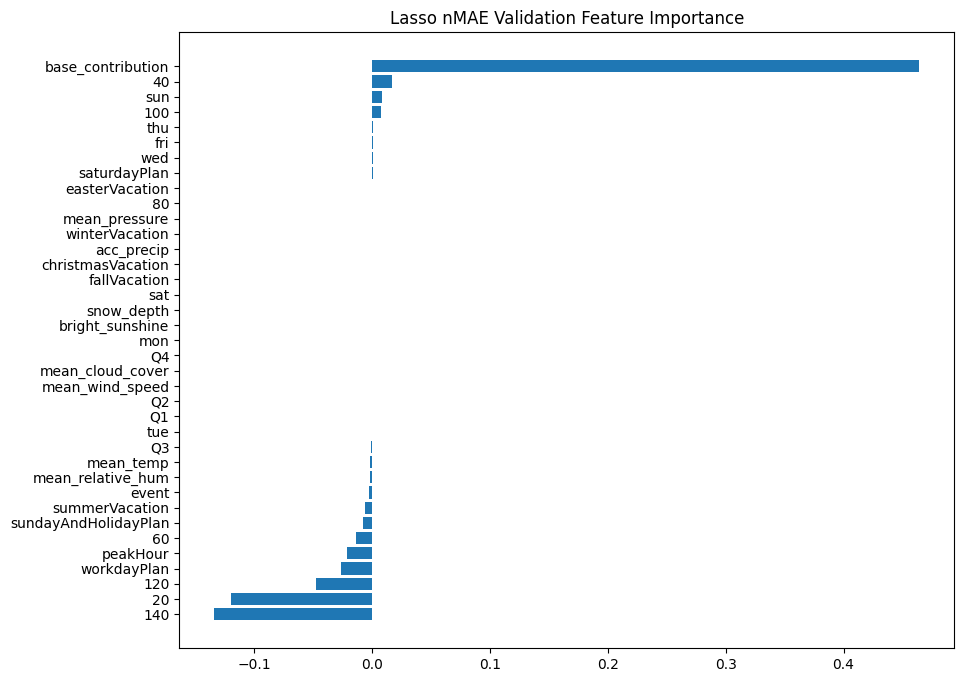

In [5]:
keys = anatomized_mae_lasso.transpose()['lasso']['14680 -> 16519'].index
values = anatomized_mae_lasso.transpose()['lasso']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'Lasso nMAE')